<a href="https://colab.research.google.com/github/asosam91/SisDist2/blob/master/SistDist2_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN

In [0]:
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/' + plantilla

urls = (plantillaURL.format(k) for k in range(1,3)) #generador
for url in urls:
  os.system(url)

In [3]:
df = pd.read_csv('yellow_tripdata_2018-01.csv')

(8759874, 17)

In [5]:
df['payment_type'].value_counts()

1    6105871
2    2598947
3      43204
4      11852
Name: payment_type, dtype: int64

calcular la fraccion dle monto total dle viaje que corresponde a la propina:

$f_p = \frac{propina}{total - propina}$

In [0]:
df['tip_fraction'] = df['tip_amount']/(df['total_amount']- df['tip_amount'])

In [10]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'tip_fraction'],
      dtype='object')

In [0]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [0]:
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

In [0]:
credito = df[df.payment_type==1]

In [15]:
credito.shape

(6105871, 19)

In [28]:
porhora = credito.groupby('hour')
porhora

In [0]:
resultado = porhora['tip_fraction'].mean()

In [50]:
resultado.plot.line(style ="-o", figsize=(15,5))
plt.ylabel("fraccion de propina")
plt.xlabel("hora del dia ")

AttributeError: ignored

In [0]:
porHoras = df.groupby('hour')
numPasajerosPorHora = porHoras['passenger_count'].mean()

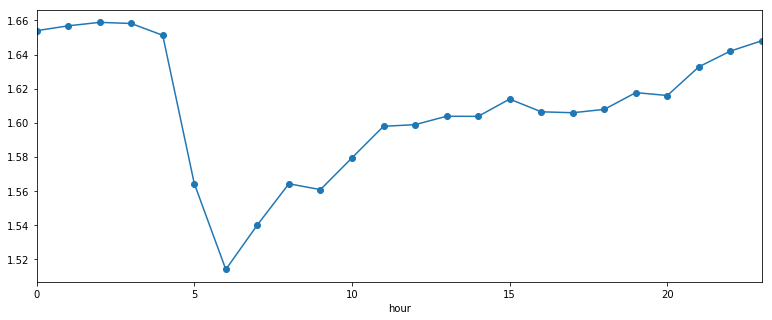

In [35]:
numPasajerosPorHora.plot.line(style="-o",figsize =(13,5))

In [0]:
df['weekday'] = df['tpep_dropoff_datetime'].dt.weekday

In [0]:
weekDayPU = df.groupby('weekday')
weekDayPUCount = weekDayPU['passenger_count'].mean()

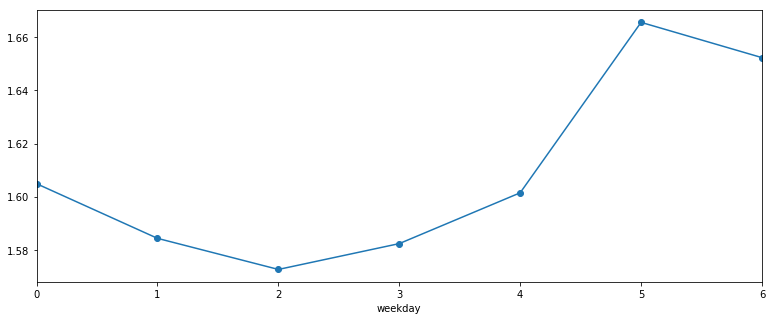

In [41]:
weekDayPUCount.plot.line(style="-o",figsize =(13,5))

## reproducimos el ejercicio de la propina usando dask

In [0]:
df = dd.read_csv("yellow_tripdata_2018-*.csv", assume_missing = True)

In [0]:
df['tip_fraction'] = df['tip_amount']/(df['total_amount']- df['tip_amount'])

In [0]:
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

In [0]:
credito = df[df.payment_type==1]
hour = credito.groupby('hour')
resultado = hour['tip_fraction'].mean()

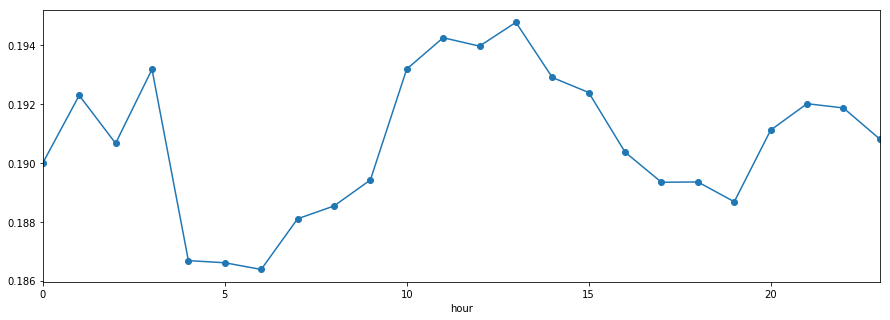

In [51]:
tip_frac = resultado.compute()
tip_frac.plot.line(style ="-o", figsize=(15,5))

hacer graficas apiladas

las 12 graficas correspondientes a cada mes mas el promedio, con dask

In [52]:
!wget http://s3.amazonaws.com/datashader-data/nyc_taxi.zip && unzip nyc_taxi.zip

--2019-06-11 17:03:18--  http://s3.amazonaws.com/datashader-data/nyc_taxi.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.109|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432291366 (412M) [application/zip]
Saving to: ‘nyc_taxi.zip’

nyc_taxi.zip        100%[===================>] 412.26M  95.3MB/s    in 4.3s    

2019-06-11 17:03:23 (95.8 MB/s) - ‘nyc_taxi.zip’ saved [432291366/432291366]

Archive:  nyc_taxi.zip
  inflating: nyc_taxi.csv            


In [69]:
%time df = pd.read_csv('nyc_taxi.csv', usecols=['dropoff_x', 'dropoff_y', 'pickup_x', 'pickup_y'])
df.tail()

CPU times: user 15 s, sys: 1.39 s, total: 16.3 s
Wall time: 16.3 s


,pickup_x,pickup_y,dropoff_x,dropoff_y
10679302,-8.232298e+06,4.980860e+06,-8.232492e+06,4.979234e+06
10679303,-8.235721e+06,4.972331e+06,-8.234857e+06,4.971131e+06
10679304,-8.235341e+06,4.975470e+06,-8.234203e+06,4.981092e+06
10679305,-8.237594e+06,4.973844e+06,-8.235618e+06,4.973722e+06
10679306,-8.233229e+06,4.977946e+06,-8.234152e+06,4.977120e+06


In [0]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [71]:
output_notebook()
muestras = df.sample(n=5000)
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=muestras['dropoff_x'], y = muestras['dropoff_y'], color = "red")
p.circle(x=muestras['pickup_x'], y = muestras['pickup_y'], color = "green")
show(p)

Loading BokehJS ...